In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import davies_bouldin_score

import pickle
import copy
from shapely import geometry
from sklearn.metrics.pairwise import euclidean_distances
import statsmodels.api as sm
from scipy.stats import linregress
from sklearn.metrics import accuracy_score
import math

/glade/work/jhayron/conda-envs/cnn_wr/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
names_reanalyses = ['ERA5',
                   'JRA3Q',
                   'NCEP_NCAR',
                   'NCEP_DOE',
                   'MERRA2']

In [3]:
dic_labels = {}
for reanalysis in names_reanalyses:
    labels_temp = pd.read_csv(f'../Data/Labels/df_labels_{reanalysis}.csv', parse_dates=True, index_col=0, names=['WR'], skiprows=1)
    labels_temp['season'] = labels_temp.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    labels_temp['season'] = labels_temp['season'].map(season_map)
    dic_labels[reanalysis] = labels_temp


dic_events = {}

for ir, reanalysis in enumerate(names_reanalyses):
    # Compute Overall Frequency of Each Class
    df_labels = copy.deepcopy(dic_labels[reanalysis])
    df_labels['season'] = df_labels.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_labels['season'] = df_labels['season'].map(season_map)
    
    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    df_events['season'] = df_events.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_events['season'] = df_events['season'].map(season_map)
    df_events['year'] = df_events.index.year
    dic_events[reanalysis] = df_events

In [18]:
def extract_n_years_around_each_year(df, N):
    """
    Extracts N years of data around each year from the input DataFrame.

    Parameters:
    - df (DataFrame): Input DataFrame containing time-indexed data.
    - N (int): Number of years to extract around each year.

    Returns:
    - dict: A dictionary where each key is a year and the corresponding value is a DataFrame
            containing N years of data centered around that year.
    """
    # Initialize an empty dictionary to store results
    result_dict = {}

    # Iterate over each unique year in the index
    for year in df.index.year.unique():
        # Define the range of years to extract
        start_year = year - N/2
        end_year = year + N/2
        
        # start_year = year - N
        # end_year = year

        # Extract data for the range of years
        data_subset = df[(df.index.year >= start_year) & (df.index.year <= end_year)]

        # Store the extracted data in the result dictionary
        result_dict[year] = data_subset

    return result_dict

def get_frequencies_labels(df_labels_temp):
    # 1. Compute Overall Frequency of Each Class
    overall_frequency = df_labels_temp['WR'].value_counts().sort_index()
    overall_frequency = overall_frequency*100/np.sum(overall_frequency)

    # Group by season and class to count the frequency
    seasonal_frequency = df_labels_temp.groupby(['season', 'WR']).size().unstack(fill_value=0)
    seasonal_percentage = seasonal_frequency.div(seasonal_frequency.sum(axis=1), axis=0) * 100
    return overall_frequency,seasonal_percentage

def get_event_freqs(df_events_temp):
    # Total number of events for each class
    total_events_per_class = df_events_temp.groupby('WR').size()
    # df_events_temp['year'] = df_events_temp.index.year
    total_years = df_events_temp['year'].nunique()
    # Calculate the average frequency of events per year for each class
    average_frequency_per_year = total_events_per_class / total_years
    # Calculate the number of events for each class per season
    events_per_season = df_events_temp.groupby(['WR', 'season']).size().unstack(fill_value=0)
    # Calculate the average frequency of events per season for each class
    # Number of unique years might differ if not every season is present each year
    average_frequency_per_season = events_per_season / total_years
    return average_frequency_per_year, average_frequency_per_season

def get_durations_events(df_events_temp):
    mean_duration_overall = df_events_temp.groupby('WR')['duration'].mean()
    # Calculate mean duration of events for each class stratified by seasons
    mean_duration_by_season = df_events_temp.groupby(['season', 'WR'])['duration'].mean()
    # mean_duration_by_season = mean_duration_by_season.reindex(range(6), fill_value=0)
    return mean_duration_overall, mean_duration_by_season

In [19]:
def get_time_series_of_frequencies(df_labels, N=30):
    dict_labels = extract_n_years_around_each_year(df_labels, N)
    years_trends = df_labels.index.year.unique()[1:]
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    series_frequencies = []
    series_frequencies_seasonal = {}
    for season in seasons:
        series_frequencies_seasonal[season] = []
    
    for year in years_trends:
        series_frequencies.append(get_frequencies_labels(dict_labels[year])[0].values)
        for season in seasons:
            series_frequencies_seasonal[season].append(get_frequencies_labels(dict_labels[year])[1].loc[season])
    
    series_frequencies = np.array(series_frequencies)
    for season in seasons:
        series_frequencies_seasonal[season] = pd.DataFrame(np.array(series_frequencies_seasonal[season]), index = years_trends)
    series_frequencies_seasonal['all'] = pd.DataFrame(series_frequencies, index = years_trends)
    return series_frequencies_seasonal

In [20]:
def get_time_series_of_eventfreqs(df_events, N=30):
    dict_events = extract_n_years_around_each_year(df_events, N)
    years_trends = df_events.index.year.unique().values[1:]
    # print(years_trends)
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    series_evfreq = []
    series_evfreq_seasonal = {}
    for season in seasons:
        series_evfreq_seasonal[season] = []
    
    for year in years_trends:
        series_evfreq.append(get_event_freqs(dict_events[year])[0].values)
        for season in seasons:
            series_evfreq_seasonal[season].append(get_event_freqs(dict_events[year])[1][season])
    
    series_evfreq = np.array(series_evfreq)
    for season in seasons:
        series_evfreq_seasonal[season] = pd.DataFrame(np.array(series_evfreq_seasonal[season]),index=years_trends)

    series_evfreq_seasonal['all'] = pd.DataFrame(series_evfreq,index=years_trends)
    return series_evfreq_seasonal

In [21]:
def get_time_series_of_durations(df_events, N=30):
    dict_events = extract_n_years_around_each_year(df_events, N)
    years_trends = df_events.index.year.unique().values[1:]
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    series_duration = []
    series_duration_seasonal = {}
    for season in seasons:
        series_duration_seasonal[season] = []
    
    for year in years_trends:
        series_duration.append(get_durations_events(dict_events[year])[0].values)
        for season in seasons:
            series_duration_seasonal[season].append(get_durations_events(dict_events[year])[1][season])
    
    series_duration = np.array(series_duration)
    for season in seasons:
        # print(season)
        # # print(series_duration_seasonal[season])
        # print(years_trends.shape)
        # if season=='Spring':
        #     return series_duration_seasonal#[season]
        series_duration_seasonal[season] = pd.DataFrame(np.array(series_duration_seasonal[season]),index=years_trends)
    series_duration_seasonal['all'] = pd.DataFrame(series_duration,index=years_trends)
    return series_duration_seasonal

In [22]:
def compute_trend_significance(series):
    ### COMPUTE TRENDS AND SIGNIFICANCE
    # Linear regression using statsmodels
    X = sm.add_constant(series.index)  # Add a constant (intercept) to the model
    model = sm.OLS(series, X).fit()  # Fit the model
    # Extract the slope (trend) and its p-value
    # return model
    s = model.params.x1
    p = model.pvalues.x1
    return s, p

def same_sign(a, b, c):
    return (a > 0 and b > 0 and c > 0) or (a < 0 and b < 0 and c < 0) or (a == 0 and b == 0 and c == 0)

In [23]:
def compute_significance_approval(series,n):
    slope1, p_value1 = compute_trend_significance(series.loc[1940+n/2:2023-n/2])
    slope2, p_value2 = compute_trend_significance(series.loc[1940+n/2:2023-n/2])
    slope3, p_value3 = compute_trend_significance(series.loc[1940+n/2:2023-n/2])
    # slope1, p_value1 = compute_trend_significance(series.loc[1979:2023])
    # slope2, p_value2 = compute_trend_significance(series.loc[1979:2023])
    # slope3, p_value3 = compute_trend_significance(series.loc[1940+n:2023])
    alpha = 0.05
    if (p_value1<alpha) & (p_value2<alpha) & (p_value3<alpha) & (same_sign(slope1,slope2,slope3)):
        return True
    else:
        return False

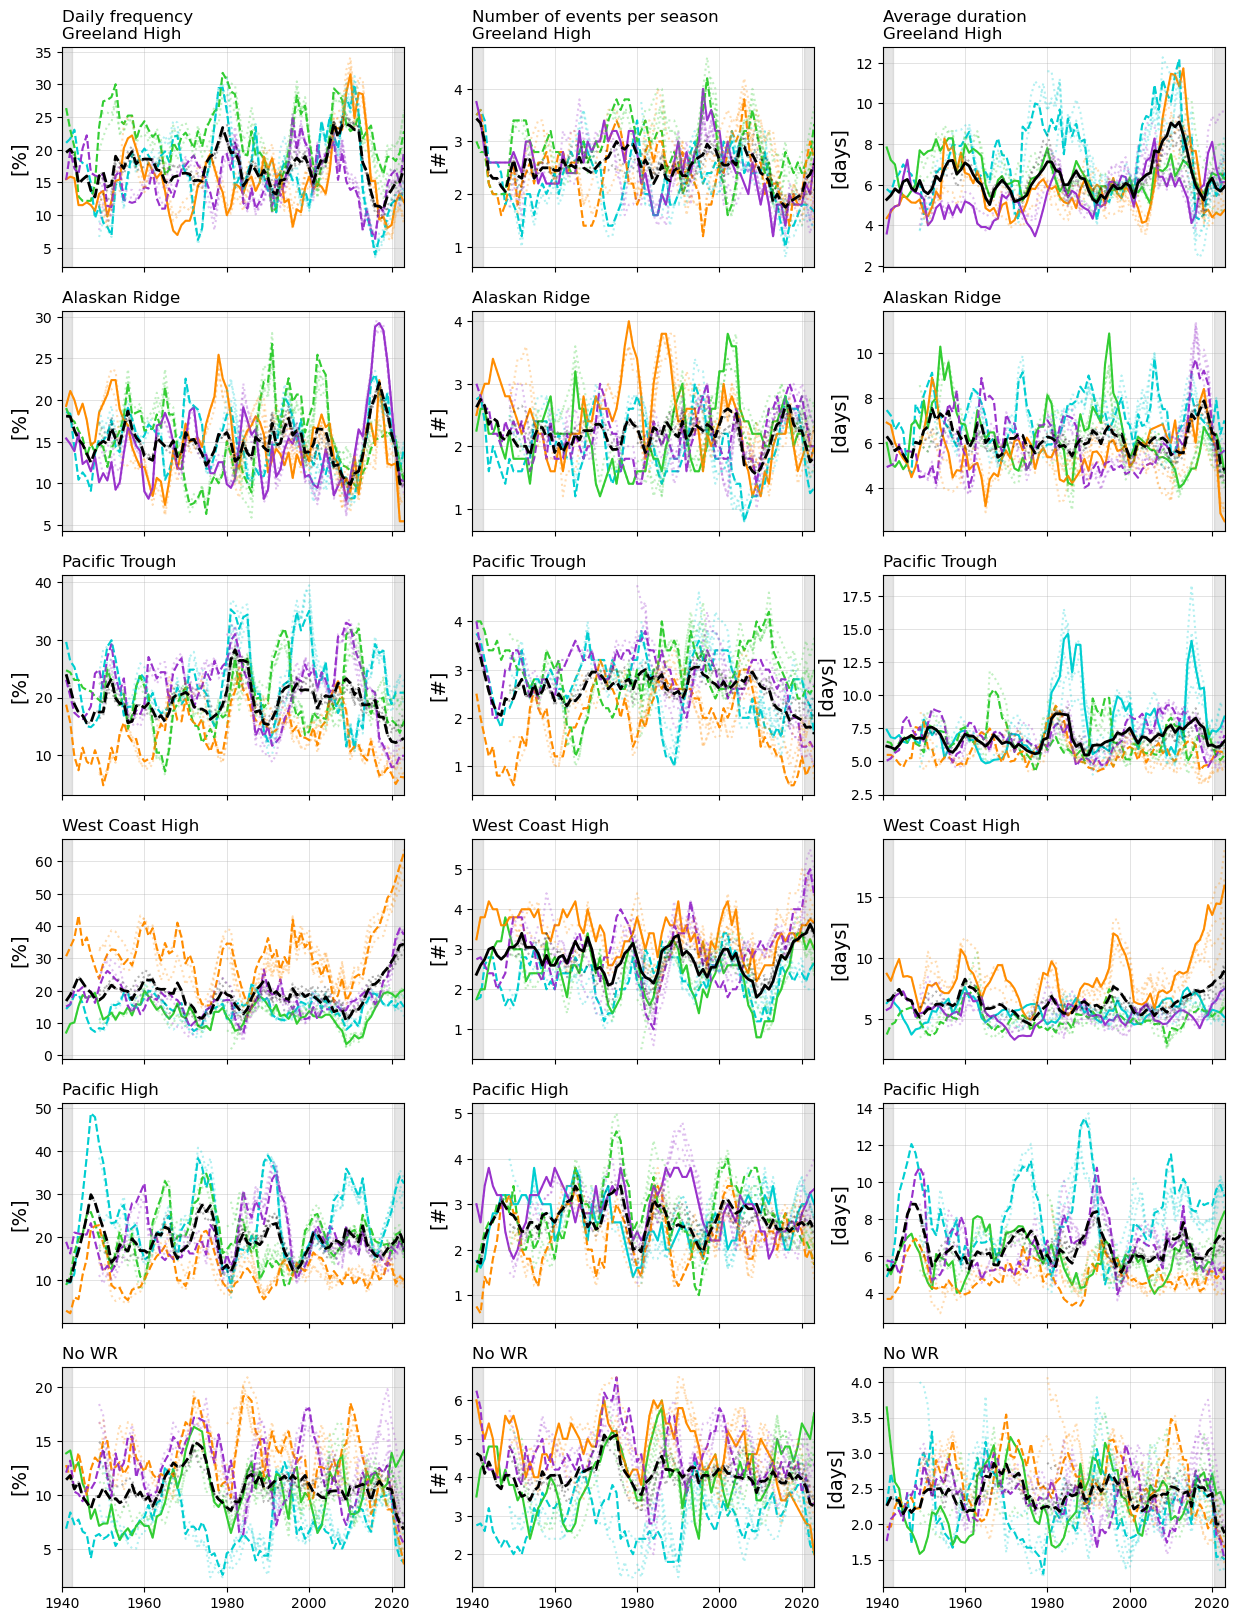

In [24]:
# Create a figure and axes for the subplots
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 20), sharex=True)

n=5
names_wrs = ["Greeland High","Alaskan Ridge","Pacific Trough","West Coast High","Pacific High","No WR"]
colors_seasons = ['darkturquoise','limegreen','darkorange','darkorchid']
seasons = ['Winter','Spring','Summer','Fall']

dic_evfreqs_series = get_time_series_of_eventfreqs(dic_events['ERA5'],n)
dic_freqs_series = get_time_series_of_frequencies(dic_labels['ERA5'],n)
dic_duration_series = get_time_series_of_durations(dic_events['ERA5'],n)

start_year_df = 1940
end_year_df = 2023

for wr in range(6):
    ls = 'solid' if compute_significance_approval(dic_freqs_series['all'][wr], n) else '--'
    axes[wr,0].plot(dic_freqs_series['all'][wr].loc[start_year_df:end_year_df],label='All',color='k',ls=ls,zorder=10,lw=2)
    for iseason,season in enumerate(seasons):
        ls = 'solid' if compute_significance_approval(dic_freqs_series[season][wr], n) else '--'
        axes[wr,0].plot(dic_freqs_series[season][wr].loc[start_year_df:end_year_df],label=season,color=colors_seasons[iseason],ls=ls)
    axes[wr,0].set_title(names_wrs[wr],loc='left')
    axes[wr,0].set_ylabel('[%]',fontsize=14)
    if wr==0:
        axes[wr,0].set_title(f'Daily frequency\n{names_wrs[wr]}',loc='left')
    
    axes[wr,0].axvspan(end_year_df-n/2, 2023, color='gray', alpha=0.2)
    axes[wr,0].axvspan(1940, start_year_df+n/2, color='gray', alpha=0.2,label = 'Less than 30 years of data')
    axes[wr,0].set_xlim(1940,2023)
    axes[wr,0].grid(alpha=0.5, lw=0.5)
    
for wr in range(6):
    ls = 'solid' if compute_significance_approval(dic_evfreqs_series['all'][wr], n) else '--'
    axes[wr,1].plot(dic_evfreqs_series['all'][wr].loc[start_year_df:end_year_df]/4,label='All',color='k',ls=ls,zorder=10,lw=2)
    for iseason,season in enumerate(seasons):
        ls = 'solid' if compute_significance_approval(dic_evfreqs_series[season][wr], n) else '--'
        axes[wr,1].plot(dic_evfreqs_series[season][wr].loc[start_year_df:end_year_df],label=season,color=colors_seasons[iseason],ls=ls)
    axes[wr,1].set_title(f'{names_wrs[wr]}',loc='left')
    axes[wr,1].set_ylabel('[#]',fontsize=14)
    if wr==0:
        axes[wr,1].set_title(f'Number of events per season\n{names_wrs[wr]}',loc='left')
    axes[wr,1].axvspan(end_year_df-n/2, 2023, color='gray', alpha=0.2)
    axes[wr,1].axvspan(1940, start_year_df+n/2, color='gray', alpha=0.2,label = 'Less than 30 years of data')
    axes[wr,1].set_xlim(1940,2023)
    axes[wr,1].grid(alpha=0.5, lw=0.5)
    
for wr in range(6):
    ls = 'solid' if compute_significance_approval(dic_duration_series['all'][wr], n) else '--'
    axes[wr,2].plot(dic_duration_series['all'][wr].loc[start_year_df:end_year_df],label='All',color='k',ls=ls,zorder=10,lw=2)
    for iseason,season in enumerate(seasons):
        ls = 'solid' if compute_significance_approval(dic_duration_series[season][wr], n) else '--'
        axes[wr,2].plot(dic_duration_series[season][wr].loc[start_year_df:end_year_df],label=season,color=colors_seasons[iseason],ls=ls)
    axes[wr,2].set_title(f'{names_wrs[wr]}',loc='left')
    axes[wr,2].set_ylabel('[days]',fontsize=14)
    if wr==0:
        axes[wr,2].set_title(f'Average duration\n{names_wrs[wr]}',loc='left')
    axes[wr,2].axvspan(end_year_df-n/2, 2023, color='gray', alpha=0.2)
    axes[wr,2].axvspan(1940, start_year_df+n/2, color='gray', alpha=0.2,label = 'Less than 30 years of data')
    axes[wr,2].set_xlim(1940,2023)
    axes[wr,2].grid(alpha=0.5, lw=0.5)
    
#### PLOT OTHER REANALYSES ###
for reanalysis in names_reanalyses:
    dic_evfreqs_series = get_time_series_of_eventfreqs(dic_events[reanalysis],n)
    dic_freqs_series = get_time_series_of_frequencies(dic_labels[reanalysis],n)
    dic_duration_series = get_time_series_of_durations(dic_events[reanalysis],n)
    ls = 'dotted'
    
    for wr in range(6):
        axes[wr,0].plot(dic_freqs_series['all'][wr].loc[start_year_df:end_year_df],label='All',color='k',ls=ls,alpha=0.3)
        for iseason,season in enumerate(seasons):
            axes[wr,0].plot(dic_freqs_series[season][wr].loc[start_year_df:end_year_df],label=season,color=colors_seasons[iseason],
                            ls=ls,alpha=0.3)

    for wr in range(6):
        axes[wr,1].plot(dic_evfreqs_series['all'][wr].loc[start_year_df:end_year_df]/4,label='All',color='k',ls=ls,alpha=0.3)
        for iseason,season in enumerate(seasons):
            axes[wr,1].plot(dic_evfreqs_series[season][wr].loc[start_year_df:end_year_df],label=season,color=colors_seasons[iseason],
                            ls=ls,alpha=0.3)

    for wr in range(6):
        axes[wr,2].plot(dic_duration_series['all'][wr].loc[start_year_df:end_year_df],label='All',color='k',ls=ls,alpha=0.3)
        for iseason,season in enumerate(seasons):
            axes[wr,2].plot(dic_duration_series[season][wr].loc[start_year_df:end_year_df],label=season,color=colors_seasons[iseason],
                            ls=ls,alpha=0.3)

plt.savefig('../Figures/TrendsReanalysis_1955_2008_5y.pdf',bbox_inches='tight')

# Not centered

In [25]:
def extract_n_years_around_each_year(df, N):
    """
    Extracts N years of data around each year from the input DataFrame.

    Parameters:
    - df (DataFrame): Input DataFrame containing time-indexed data.
    - N (int): Number of years to extract around each year.

    Returns:
    - dict: A dictionary where each key is a year and the corresponding value is a DataFrame
            containing N years of data centered around that year.
    """
    # Initialize an empty dictionary to store results
    result_dict = {}

    # Iterate over each unique year in the index
    for year in df.index.year.unique():
        # Define the range of years to extract
        # start_year = year - N/2
        # end_year = year + N/2
        
        start_year = year - N
        end_year = year

        # Extract data for the range of years
        data_subset = df[(df.index.year >= start_year) & (df.index.year <= end_year)]

        # Store the extracted data in the result dictionary
        result_dict[year] = data_subset

    return result_dict

def compute_significance_approval(series,n):
    slope1, p_value1 = compute_trend_significance(series.loc[1940+n:2023])
    slope2, p_value2 = compute_trend_significance(series.loc[1940+n:2023])
    slope3, p_value3 = compute_trend_significance(series.loc[1979:2023])
    alpha = 0.05
    if (p_value1<alpha) & (p_value2<alpha) & (p_value3<alpha) & (same_sign(slope1,slope2,slope3)):
        return True
    else:
        return False

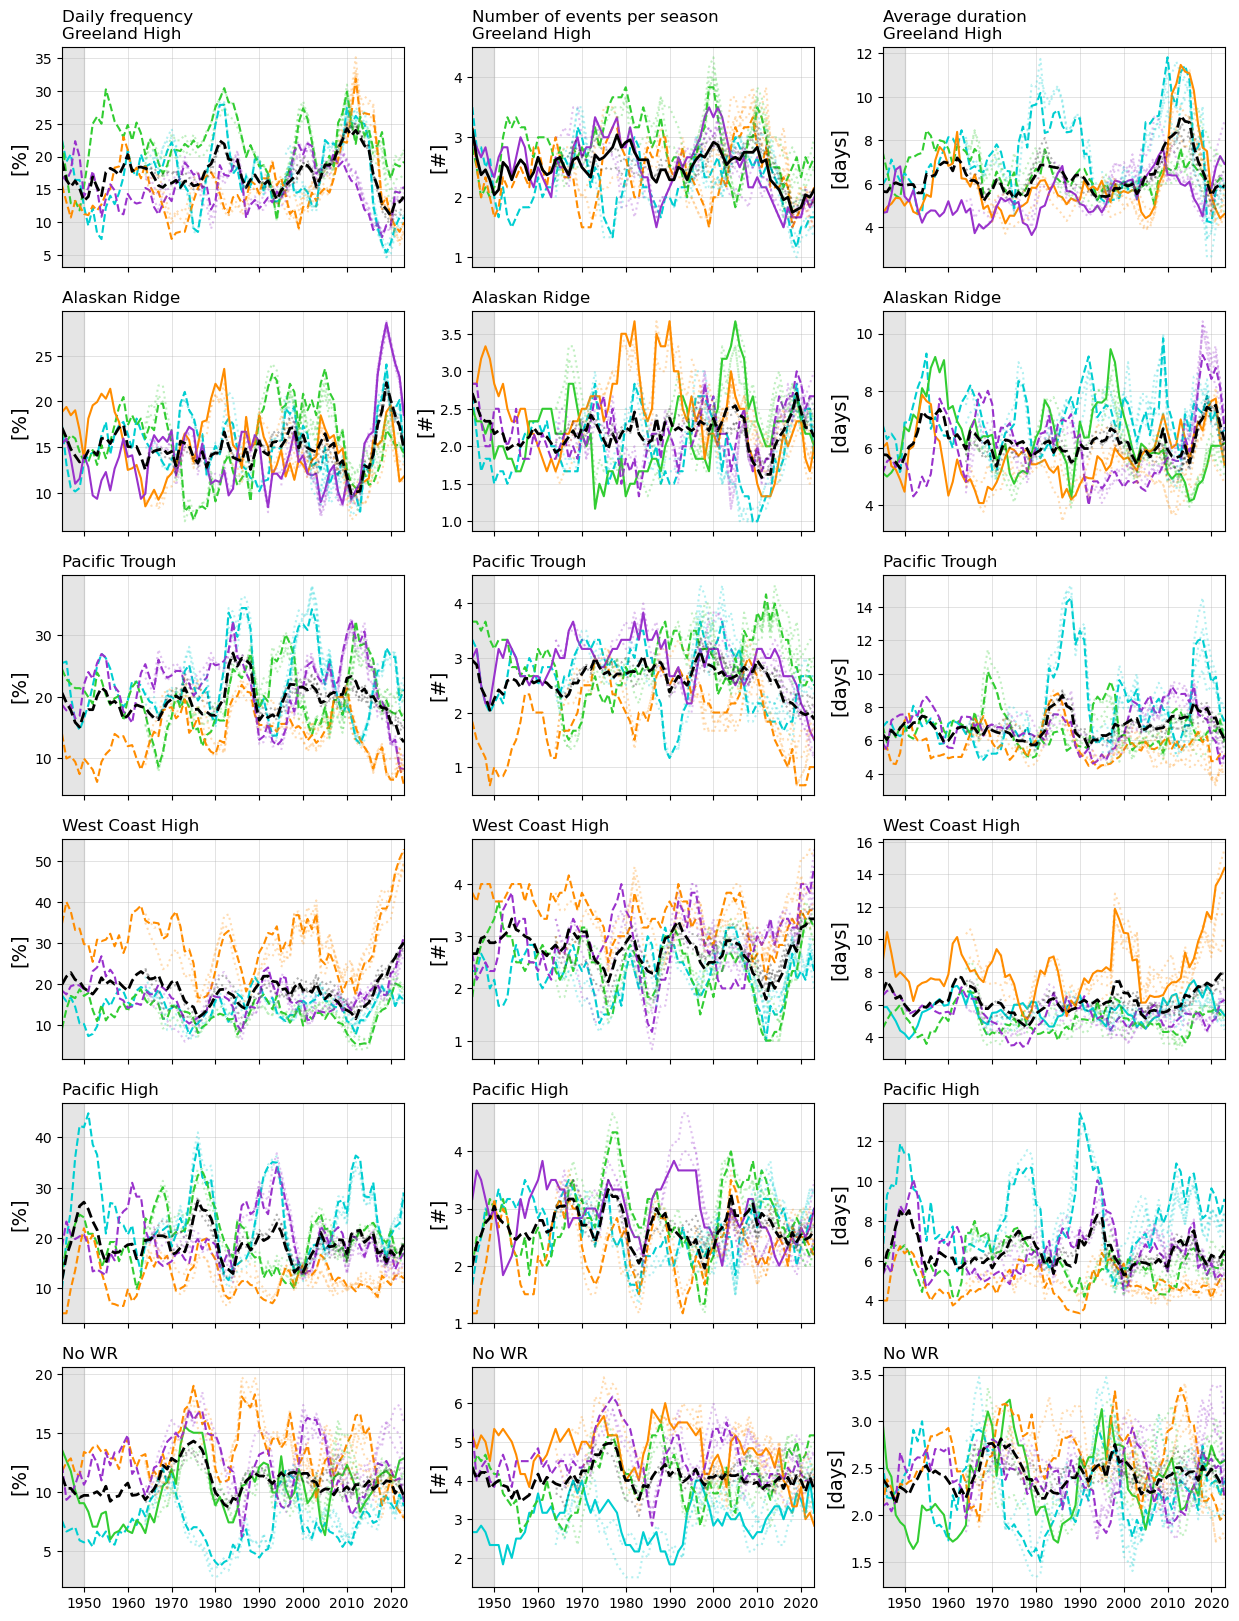

In [26]:
# Create a figure and axes for the subplots
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 20), sharex=True)

n=5
names_wrs = ["Greeland High","Alaskan Ridge","Pacific Trough","West Coast High","Pacific High","No WR"]
colors_seasons = ['darkturquoise','limegreen','darkorange','darkorchid']
seasons = ['Winter','Spring','Summer','Fall']

dic_evfreqs_series = get_time_series_of_eventfreqs(dic_events['ERA5'],n)
dic_freqs_series = get_time_series_of_frequencies(dic_labels['ERA5'],n)
dic_duration_series = get_time_series_of_durations(dic_events['ERA5'],n)

start_year_df = 1945
end_year_df = 2023

for wr in range(6):
    ls = 'solid' if compute_significance_approval(dic_freqs_series['all'][wr], n) else '--'
    axes[wr,0].plot(dic_freqs_series['all'][wr].loc[start_year_df:end_year_df],label='All',color='k',ls=ls,zorder=10,lw=2)
    for iseason,season in enumerate(seasons):
        ls = 'solid' if compute_significance_approval(dic_freqs_series[season][wr], n) else '--'
        axes[wr,0].plot(dic_freqs_series[season][wr].loc[start_year_df:end_year_df],label=season,color=colors_seasons[iseason],ls=ls)
    axes[wr,0].set_title(names_wrs[wr],loc='left')
    axes[wr,0].set_ylabel('[%]',fontsize=14)
    if wr==0:
        axes[wr,0].set_title(f'Daily frequency\n{names_wrs[wr]}',loc='left')
    axes[wr,0].axvspan(start_year_df, start_year_df+n, color='gray', alpha=0.2,label = 'Less than 30 years of data')
    axes[wr,0].set_xlim(start_year_df,2023)
    axes[wr,0].grid(alpha=0.5, lw=0.5)
    
for wr in range(6):
    ls = 'solid' if compute_significance_approval(dic_evfreqs_series['all'][wr], n) else '--'
    axes[wr,1].plot(dic_evfreqs_series['all'][wr].loc[start_year_df:end_year_df]/4,label='All',color='k',ls=ls,zorder=10,lw=2)
    for iseason,season in enumerate(seasons):
        ls = 'solid' if compute_significance_approval(dic_evfreqs_series[season][wr], n) else '--'
        axes[wr,1].plot(dic_evfreqs_series[season][wr].loc[start_year_df:end_year_df],label=season,color=colors_seasons[iseason],ls=ls)
    axes[wr,1].set_title(f'{names_wrs[wr]}',loc='left')
    axes[wr,1].set_ylabel('[#]',fontsize=14)
    if wr==0:
        axes[wr,1].set_title(f'Number of events per season\n{names_wrs[wr]}',loc='left')
    axes[wr,1].axvspan(start_year_df, start_year_df+n, color='gray', alpha=0.2,label = 'Less than 30 years of data')
    axes[wr,1].set_xlim(start_year_df,2023)
    axes[wr,1].grid(alpha=0.5, lw=0.5)
    
for wr in range(6):
    ls = 'solid' if compute_significance_approval(dic_duration_series['all'][wr], n) else '--'
    axes[wr,2].plot(dic_duration_series['all'][wr].loc[start_year_df:end_year_df],label='All',color='k',ls=ls,zorder=10,lw=2)
    for iseason,season in enumerate(seasons):
        ls = 'solid' if compute_significance_approval(dic_duration_series[season][wr], n) else '--'
        axes[wr,2].plot(dic_duration_series[season][wr].loc[start_year_df:end_year_df],label=season,color=colors_seasons[iseason],ls=ls)
    axes[wr,2].set_title(f'{names_wrs[wr]}',loc='left')
    axes[wr,2].set_ylabel('[days]',fontsize=14)
    if wr==0:
        axes[wr,2].set_title(f'Average duration\n{names_wrs[wr]}',loc='left')
    axes[wr,2].axvspan(start_year_df, start_year_df+n, color='gray', alpha=0.2,label = 'Less than 30 years of data')
    axes[wr,2].set_xlim(start_year_df,2023)
    axes[wr,2].grid(alpha=0.5, lw=0.5)
    
#### PLOT OTHER REANALYSES ###
for reanalysis in names_reanalyses[1:]:
    dic_evfreqs_series = get_time_series_of_eventfreqs(dic_events[reanalysis],n)
    dic_freqs_series = get_time_series_of_frequencies(dic_labels[reanalysis],n)
    dic_duration_series = get_time_series_of_durations(dic_events[reanalysis],n)
    ls = 'dotted'
    
    for wr in range(6):
        axes[wr,0].plot(dic_freqs_series['all'][wr].iloc[15:],label='All',color='k',ls=ls,alpha=0.3)
        for iseason,season in enumerate(seasons):
            axes[wr,0].plot(dic_freqs_series[season][wr].iloc[15:],label=season,color=colors_seasons[iseason],
                            ls=ls,alpha=0.3)

    for wr in range(6):
        axes[wr,1].plot(dic_evfreqs_series['all'][wr].iloc[15:]/4,label='All',color='k',ls=ls,alpha=0.3)
        for iseason,season in enumerate(seasons):
            axes[wr,1].plot(dic_evfreqs_series[season][wr].iloc[15:],label=season,color=colors_seasons[iseason],
                            ls=ls,alpha=0.3)

    for wr in range(6):
        axes[wr,2].plot(dic_duration_series['all'][wr].iloc[15:],label='All',color='k',ls=ls,alpha=0.3)
        for iseason,season in enumerate(seasons):
            axes[wr,2].plot(dic_duration_series[season][wr].iloc[15:],label=season,color=colors_seasons[iseason],
                            ls=ls,alpha=0.3)
            
plt.savefig('../Figures/TrendsReanalysis_1970_2023_5y.pdf',bbox_inches='tight')

In [29]:
dic_labels['ERA5']['1979':'2023']

,WR,season
1979-01-01,1,Winter
1979-01-02,1,Winter
1979-01-03,1,Winter
1979-01-04,1,Winter
1979-01-05,1,Winter
...,...,...
2023-11-27,5,Fall
2023-11-28,4,Fall
2023-11-29,4,Fall
2023-11-30,2,Fall
